# Investment Prediction - Model Training (UPDATED)
## Сбер Хакатон - Обновлено под реальные данные

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Устанавливаем seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Random Seed: {RANDOM_SEED}")
print("Notebook обновлен под реальную структуру данных!")

Random Seed: 42
Notebook обновлен под реальную структуру данных!


## 1. Загрузка данных

In [23]:
# Загружаем данные
train_df = pd.read_csv('invest_train.csv')
test_df = pd.read_csv('invest_test_public.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\nКолонки в train:")
print(train_df.columns.tolist())
print("\nПервые строки:")
train_df.head()

Train shape: (6000, 10)
Test shape: (1000, 9)

Колонки в train:
['customer_id', 'age', 'balance', 'risk_profile', 'marketing_channel', 'offer_amount', 'previous_investments', 'responded_before', 'membership_tier', 'accepted']

Первые строки:


,customer_id,age,balance,risk_profile,marketing_channel,offer_amount,previous_investments,responded_before,membership_tier,accepted
0,0,75,199122.20,low,phone,79471,0,0,platinum,0
1,1,72,182826.57,high,in_branch,59413,1,1,gold,1
2,2,82,119785.23,high,sms,33092,1,1,gold,1
3,3,23,320109.79,high,sms,34806,1,0,standard,0
4,4,68,166134.85,low,email,66491,0,0,standard,0


## 2. Exploratory Data Analysis (EDA)

In [24]:
print("="*60)
print("ИНФОРМАЦИЯ О ДАННЫХ")
print("="*60)
train_df.info()
print("\n" + "="*60)
print("СТАТИСТИКА")
print("="*60)
train_df.describe()

ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           6000 non-null   int64  
 1   age                   6000 non-null   int64  
 2   balance               6000 non-null   float64
 3   risk_profile          6000 non-null   object 
 4   marketing_channel     6000 non-null   object 
 5   offer_amount          6000 non-null   int64  
 6   previous_investments  6000 non-null   int64  
 7   responded_before      6000 non-null   int64  
 8   membership_tier       6000 non-null   object 
 9   accepted              6000 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 468.9+ KB

СТАТИСТИКА


,customer_id,age,balance,offer_amount,previous_investments,responded_before,accepted
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,2999.500000,53.256833,251402.467837,52765.267500,0.507667,0.493333,0.725333
std,1732.195139,20.733576,146629.547942,27536.358643,0.499983,0.499997,0.446383
min,0.000000,18.000000,25.380000,5001.000000,0.000000,0.000000,0.000000
25%,1499.750000,35.000000,125036.747500,29083.750000,0.000000,0.000000,0.000000
50%,2999.500000,54.000000,250333.235000,53043.500000,1.000000,0.000000,1.000000
75%,4499.250000,71.000000,381066.040000,76592.250000,1.000000,1.000000,1.000000
max,5999.000000,89.000000,499922.130000,99974.000000,1.000000,1.000000,1.000000


In [25]:
# Проверка пропущенных значений и целевой переменной
print("Пропущенные значения:")
print(train_df.isnull().sum())
print("\n" + "="*60)
print("Распределение целевой переменной:")
print(train_df['accepted'].value_counts())
print(f"\nДоля positive (accepted=1): {train_df['accepted'].mean():.2%}")

Пропущенные значения:
customer_id             0
age                     0
balance                 0
risk_profile            0
marketing_channel       0
offer_amount            0
previous_investments    0
responded_before        0
membership_tier         0
accepted                0
dtype: int64

Распределение целевой переменной:
accepted
1    4352
0    1648
Name: count, dtype: int64

Доля positive (accepted=1): 72.53%


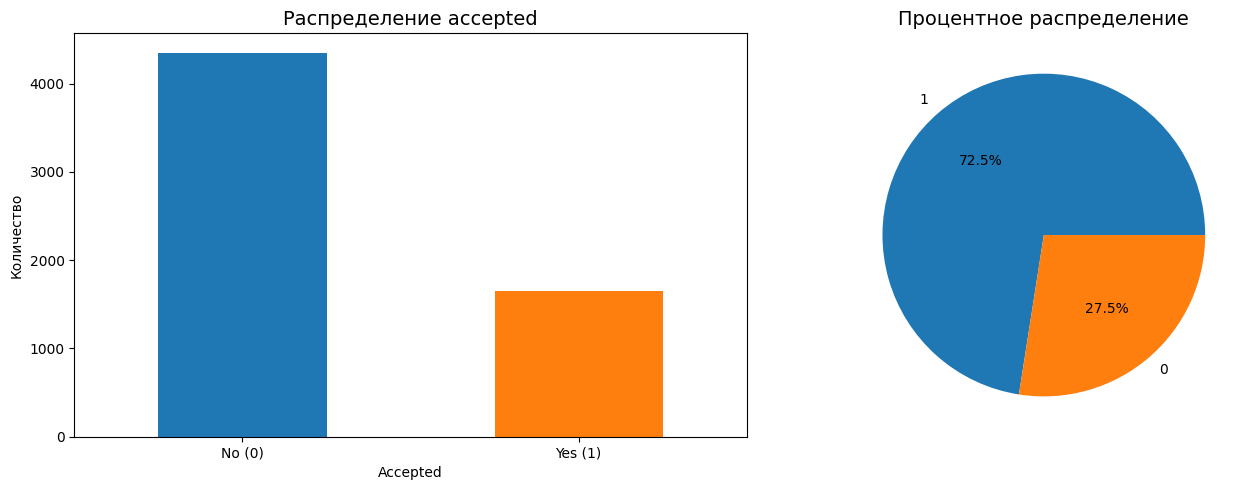

In [26]:
# Визуализация целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df['accepted'].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Распределение accepted', fontsize=14)
axes[0].set_xlabel('Accepted')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

train_df['accepted'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Процентное распределение', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

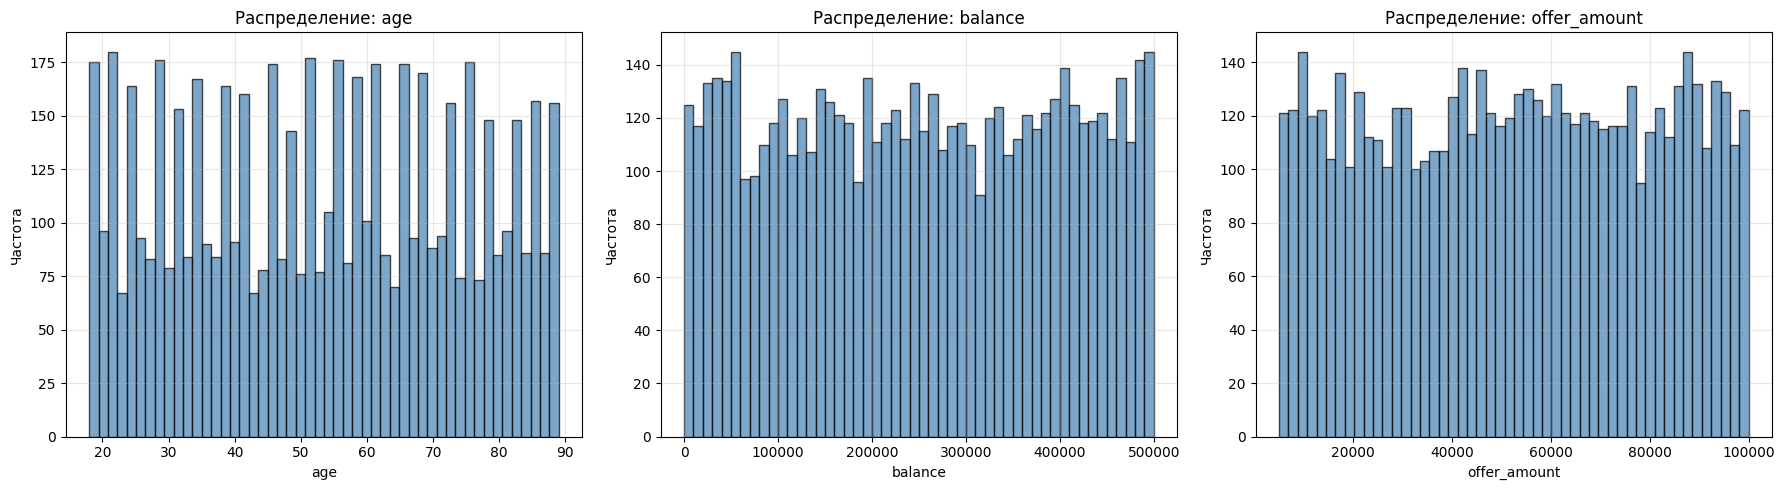

In [27]:
# Анализ числовых признаков
numeric_features = ['age', 'balance', 'offer_amount']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(numeric_features):
    axes[idx].hist(train_df[feature], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    axes[idx].set_title(f'Распределение: {feature}', fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Частота')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

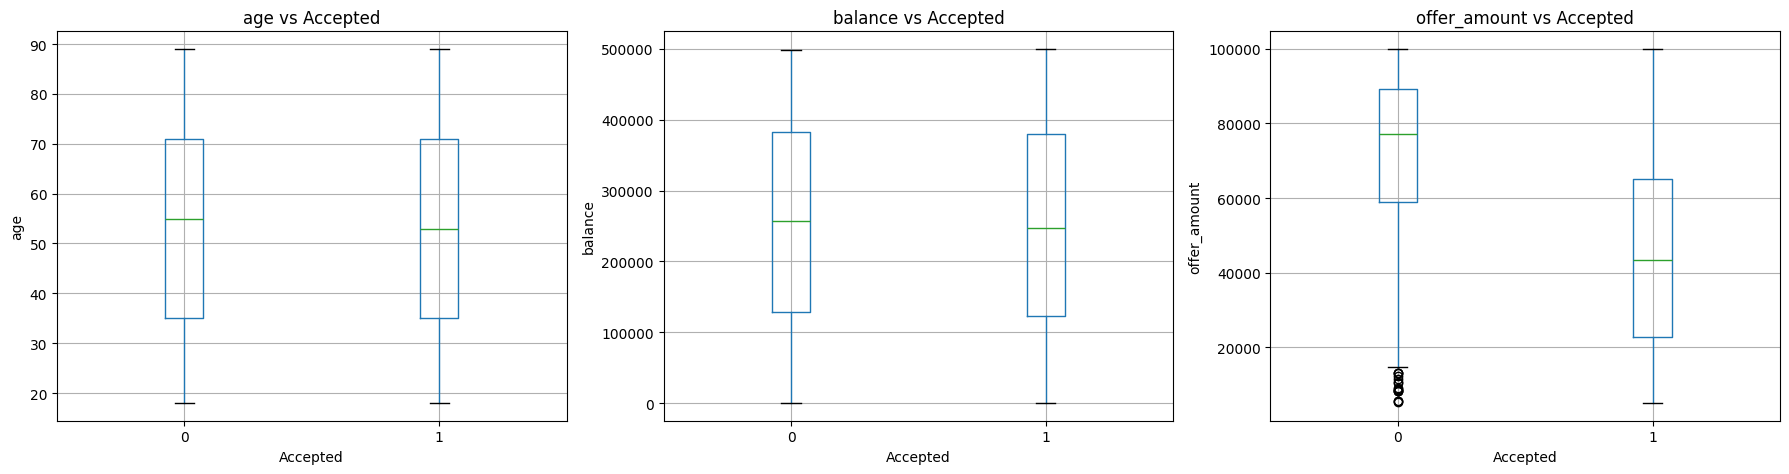

In [28]:
# Boxplots по целевой переменной
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(numeric_features):
    train_df.boxplot(column=feature, by='accepted', ax=axes[idx])
    axes[idx].set_title(f'{feature} vs Accepted')
    axes[idx].set_xlabel('Accepted')
    axes[idx].set_ylabel(feature)

plt.suptitle('')
plt.tight_layout()
plt.show()

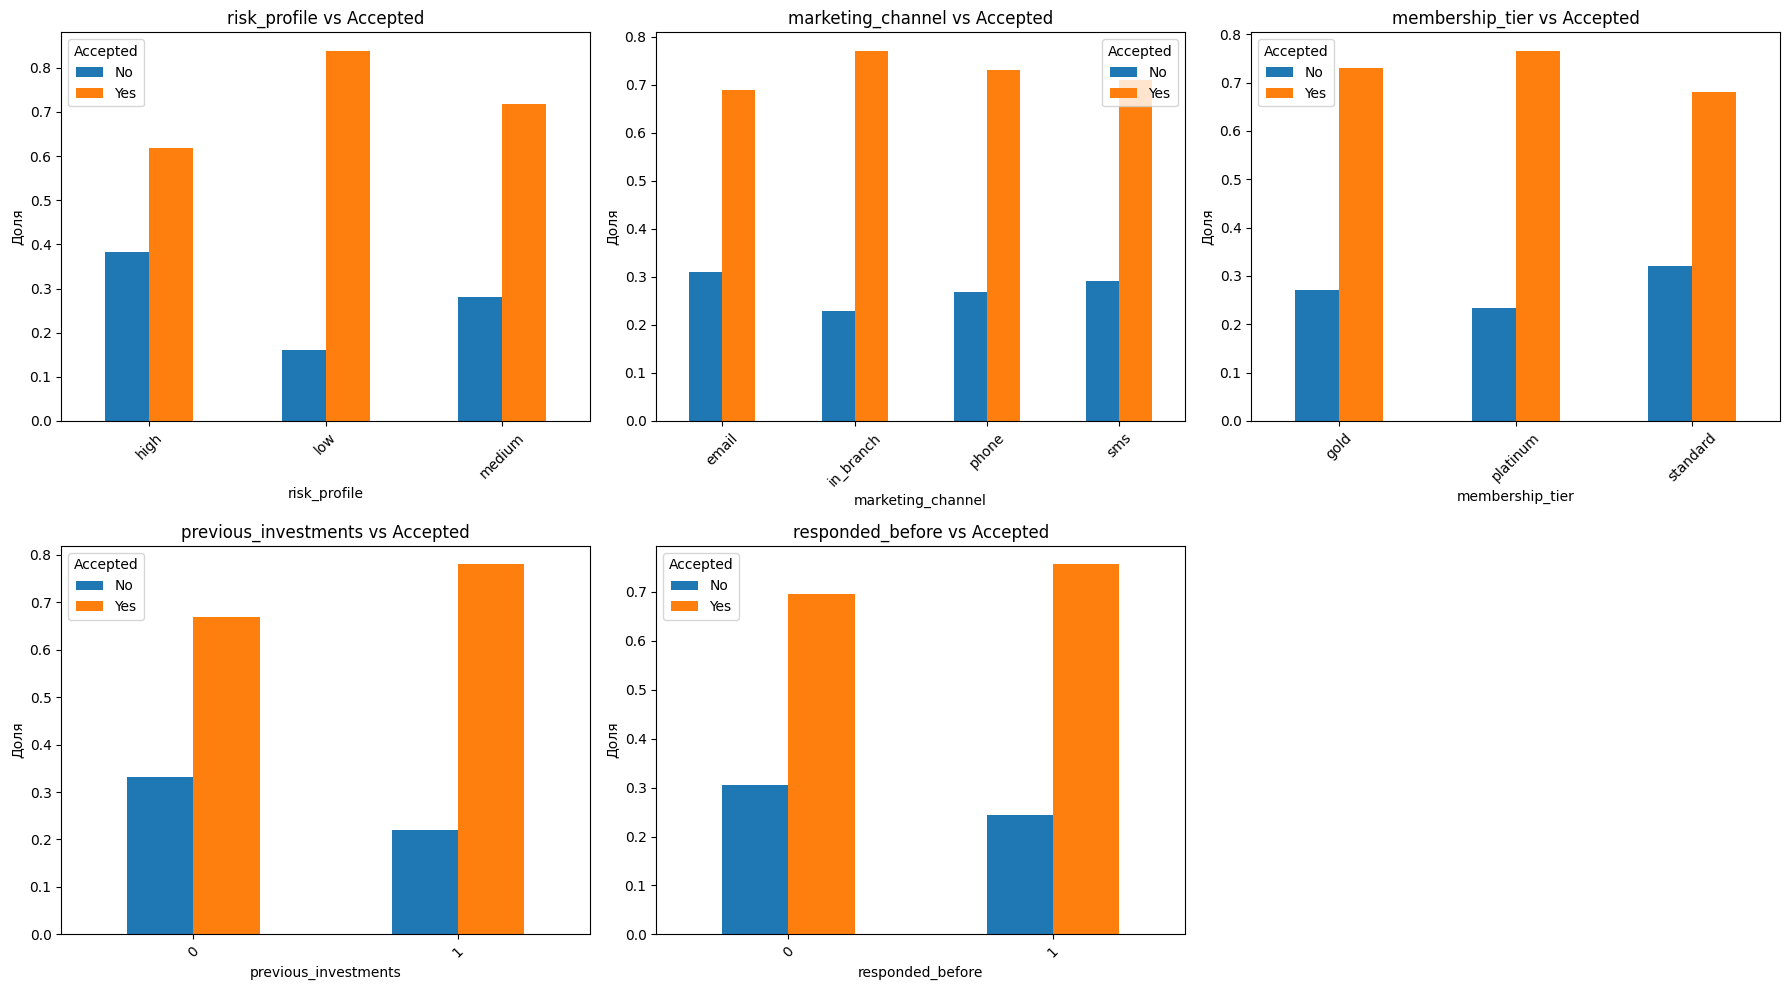

In [29]:
# Анализ категориальных признаков
categorical_features = ['risk_profile', 'marketing_channel', 'membership_tier', 'previous_investments', 'responded_before']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    pd.crosstab(train_df[feature], train_df['accepted'], normalize='index').plot(
        kind='bar', ax=axes[idx], stacked=False, color=['#1f77b4', '#ff7f0e']
    )
    axes[idx].set_title(f'{feature} vs Accepted', fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Доля')
    axes[idx].legend(['No', 'Yes'], title='Accepted')
    axes[idx].tick_params(axis='x', rotation=45)

# Скрываем лишний subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

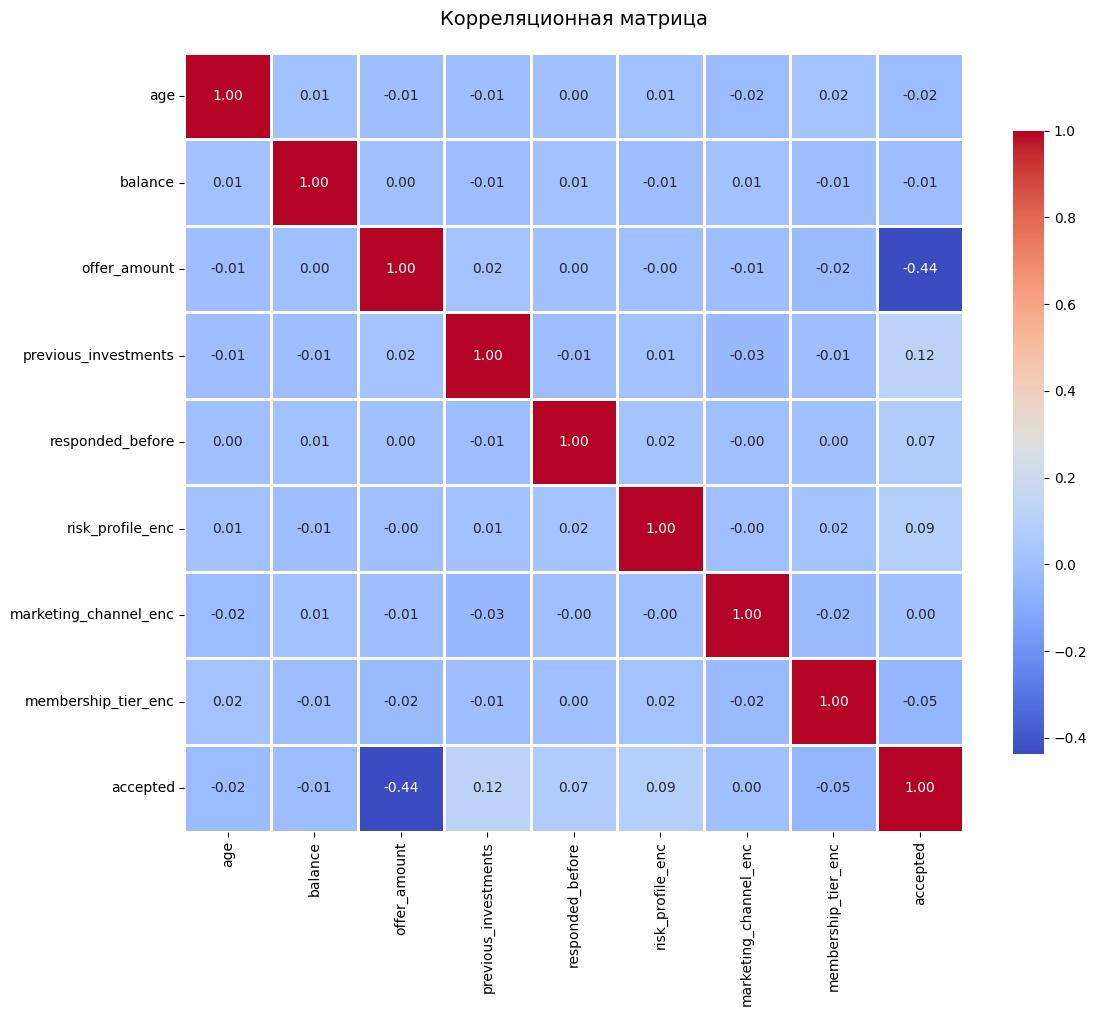

In [30]:
# Корреляционная матрица
corr_df = train_df.copy()
le = LabelEncoder()
corr_df['risk_profile_enc'] = le.fit_transform(corr_df['risk_profile'])
corr_df['marketing_channel_enc'] = le.fit_transform(corr_df['marketing_channel'])
corr_df['membership_tier_enc'] = le.fit_transform(corr_df['membership_tier'])

correlation_features = ['age', 'balance', 'offer_amount', 'previous_investments', 
                        'responded_before', 'risk_profile_enc', 'marketing_channel_enc', 
                        'membership_tier_enc', 'accepted']

plt.figure(figsize=(12, 10))
correlation_matrix = corr_df[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [31]:
def preprocess_data(df, is_train=True):
    """
    Препроцессинг данных под реальную структуру
    """
    df = df.copy()
    
    # 1. Соотношение offer к балансу
    df['offer_to_balance_ratio'] = df['offer_amount'] / (df['balance'] + 1)
    
    # 2. Опытный инвестор
    df['experienced_investor'] = (df['previous_investments'] & df['responded_before']).astype(int)
    
    # 3. Группы по возрасту
    df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100], 
                             labels=['young', 'middle', 'senior', 'elderly'])
    
    # 4. Группы по балансу
    df['balance_group'] = pd.cut(df['balance'], 
                                  bins=[-np.inf, 100000, 250000, 400000, np.inf],
                                  labels=['low', 'medium', 'high', 'very_high'])
    
    # 5. Группы по размеру предложения
    df['offer_size'] = pd.cut(df['offer_amount'],
                               bins=[-np.inf, 40000, 60000, np.inf],
                               labels=['small', 'medium', 'large'])
    
    # 6. High value customer (большой баланс + опыт)
    df['high_value_customer'] = ((df['balance'] > df['balance'].median()) & 
                                  (df['previous_investments'] == 1)).astype(int)
    
    # 7. Активность клиента
    df['is_active'] = (df['responded_before'] == 1).astype(int)
    
    # One-Hot Encoding для всех категориальных признаков
    df = pd.get_dummies(df, columns=['risk_profile', 'marketing_channel', 'membership_tier',
                                     'age_group', 'balance_group', 'offer_size'], 
                       drop_first=False)
    
    return df

# Применяем препроцессинг
print("Применение feature engineering...")
train_processed = preprocess_data(train_df, is_train=True)
test_processed = preprocess_data(test_df, is_train=False)

print(f"\nTrain shape после обработки: {train_processed.shape}")
print(f"Test shape после обработки: {test_processed.shape}")
print(f"\nКоличество признаков: {train_processed.shape[1]}")

Применение feature engineering...

Train shape после обработки: (6000, 32)
Test shape после обработки: (1000, 31)

Количество признаков: 32


In [32]:
# Подготовка данных для обучения
X = train_processed.drop(['customer_id', 'accepted'], axis=1)
y = train_processed['accepted']

X_test_full = test_processed.drop(['customer_id'], axis=1)

# Выравнивание признаков
missing_cols = set(X.columns) - set(X_test_full.columns)
for col in missing_cols:
    X_test_full[col] = 0
X_test_full = X_test_full[X.columns]

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test_full.shape}")
print(f"\nКоличество признаков: {X.shape[1]}")

X_train: (4800, 30)
X_val: (1200, 30)
X_test: (1000, 30)

Количество признаков: 30


## 4. Обучение моделей

In [33]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n{'='*60}")
    print(f"Модель: {model_name}")
    print(f"{'='*60}")
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    print(f"Train F1: {train_f1:.4f}")
    print(f"Val F1: {val_f1:.4f}")
    print(f"\nClassification Report (Validation):")
    print(classification_report(y_val, y_val_pred))
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    return model, val_f1

results = {}

In [34]:
# 1. CatBoost (лучшая модель)
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_state=RANDOM_SEED,
    auto_class_weights='Balanced',
    verbose=0
)
catboost_model, cb_f1 = evaluate_model(catboost_model, X_train, y_train, X_val, y_val, "CatBoost")
results['CatBoost'] = cb_f1


Модель: CatBoost
Train F1: 0.8715
Val F1: 0.8181

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       330
           1       0.89      0.76      0.82       870

    accuracy                           0.76      1200
   macro avg       0.71      0.75      0.72      1200
weighted avg       0.79      0.76      0.76      1200

CV F1: 0.8148 (+/- 0.0080)


In [35]:
# 2. XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    eval_metric='logloss'
)
xgb_model, xgb_f1 = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, "XGBoost")
results['XGBoost'] = xgb_f1


Модель: XGBoost
Train F1: 0.9005
Val F1: 0.8181

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       330
           1       0.89      0.76      0.82       870

    accuracy                           0.76      1200
   macro avg       0.71      0.75      0.72      1200
weighted avg       0.79      0.76      0.76      1200

CV F1: 0.8146 (+/- 0.0066)


In [36]:
# 3. LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    class_weight='balanced',
    verbose=-1
)
lgbm_model, lgbm_f1 = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val, "LightGBM")
results['LightGBM'] = lgbm_f1


Модель: LightGBM
Train F1: 0.9084
Val F1: 0.8196

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       330
           1       0.88      0.77      0.82       870

    accuracy                           0.76      1200
   macro avg       0.71      0.74      0.72      1200
weighted avg       0.79      0.76      0.76      1200

CV F1: 0.8164 (+/- 0.0089)


In [37]:
# 4. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=RANDOM_SEED,
    class_weight='balanced',
    n_jobs=-1
)
rf_model, rf_f1 = evaluate_model(rf_model, X_train, y_train, X_val, y_val, "Random Forest")
results['Random Forest'] = rf_f1


Модель: Random Forest
Train F1: 0.9068
Val F1: 0.8340

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       330
           1       0.88      0.79      0.83       870

    accuracy                           0.77      1200
   macro avg       0.72      0.75      0.73      1200
weighted avg       0.79      0.77      0.78      1200

CV F1: 0.8296 (+/- 0.0086)



СРАВНЕНИЕ МОДЕЛЕЙ
               F1-Score
Random Forest  0.834037
LightGBM       0.819632
XGBoost        0.818069
CatBoost       0.818069


<Figure size 1000x600 with 0 Axes>

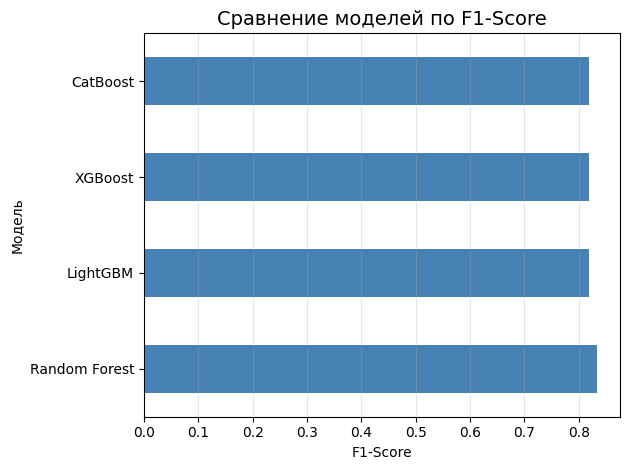


>>> Лучшая модель: Random Forest (F1=0.8340)


In [38]:
# Сравнение результатов
print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1-Score'])
results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df)

plt.figure(figsize=(10, 6))
results_df.plot(kind='barh', legend=False, color='steelblue')
plt.title('Сравнение моделей по F1-Score', fontsize=14)
plt.xlabel('F1-Score')
plt.ylabel('Модель')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_model_name = results_df.index[0]
print(f"\n>>> Лучшая модель: {best_model_name} (F1={results_df.iloc[0]['F1-Score']:.4f})")

## 5. Feature Importance

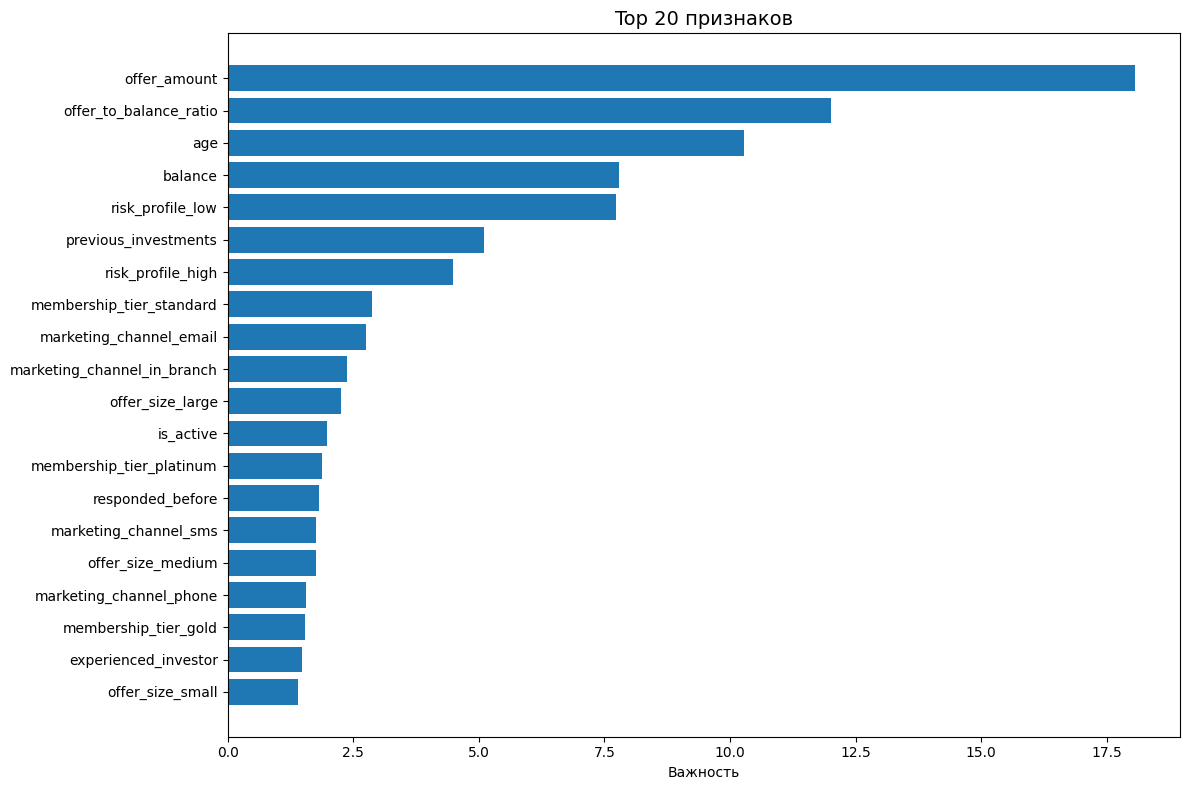

Top 15 признаков:
                        feature  importance
2                  offer_amount   18.055364
5        offer_to_balance_ratio   12.010022
0                           age   10.273027
1                       balance    7.784892
10             risk_profile_low    7.725738
3          previous_investments    5.108259
9             risk_profile_high    4.482437
18     membership_tier_standard    2.873357
12      marketing_channel_email    2.753643
13  marketing_channel_in_branch    2.384896
29             offer_size_large    2.264756
8                     is_active    1.968755
17     membership_tier_platinum    1.886236
4              responded_before    1.819732
15        marketing_channel_sms    1.759660


In [39]:
# Важность признаков (CatBoost)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': catboost_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Важность')
plt.title('Top 20 признаков', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 15 признаков:")
print(feature_importance.head(15))

## 6. Обучение финальной модели и генерация предсказаний

In [40]:
# Обучаем финальную модель на всех данных
print("Обучение финальной модели на всех данных...")
final_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_state=RANDOM_SEED,
    auto_class_weights='Balanced',
    verbose=0
)
final_model.fit(X, y)

# Сохранение
joblib.dump(final_model, f'best_model_seed_{RANDOM_SEED}.pkl')
joblib.dump(X.columns.tolist(), 'feature_names.pkl')

print(f"\n✓ Модель: best_model_seed_{RANDOM_SEED}.pkl")
print(f"✓ Признаки: feature_names.pkl")

Обучение финальной модели на всех данных...

✓ Модель: best_model_seed_42.pkl
✓ Признаки: feature_names.pkl


In [41]:
# Генерация предсказаний
test_predictions = final_model.predict(X_test_full)

submission = pd.DataFrame({
    'customer_id': test_df['customer_id'],
    'accepted': test_predictions
})

submission_filename = f'submission_seed_{RANDOM_SEED}.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n{'='*60}")
print(f"✓ Submission: {submission_filename}")
print(f"{'='*60}")
print(f"\nРаспределение:")
print(submission['accepted'].value_counts())
print(f"\nДоля positive: {submission['accepted'].mean():.2%}")
print("\nПервые 10 строк:")
print(submission.head(10))


✓ Submission: submission_seed_42.csv

Распределение:
accepted
1    596
0    404
Name: count, dtype: int64

Доля positive: 59.60%

Первые 10 строк:
   customer_id  accepted
0         6000         1
1         6002         1
2         6004         0
3         6006         0
4         6008         1
5         6010         0
6         6012         1
7         6014         1
8         6016         0
9         6018         1


## 7. Итоговая сводка

In [42]:
print("\n" + "="*80)
print("ИТОГОВАЯ СВОДКА")
print("="*80)
print(f"Random Seed: {RANDOM_SEED}")
print(f"Лучшая модель: {best_model_name}")
print(f"Val F1-Score: {results[best_model_name]:.4f}")
print(f"\nПризнаков: {X.shape[1]}")
print(f"Train samples: {X.shape[0]}")
print(f"Test samples: {X_test_full.shape[0]}")
print(f"\nФайлы:")
print(f"  - best_model_seed_{RANDOM_SEED}.pkl")
print(f"  - feature_names.pkl")
print(f"  - {submission_filename}")
print("="*80)
print("\nГОТОВО К SUBMISSION!")


ИТОГОВАЯ СВОДКА
Random Seed: 42
Лучшая модель: Random Forest
Val F1-Score: 0.8340

Признаков: 30
Train samples: 6000
Test samples: 1000

Файлы:
  - best_model_seed_42.pkl
  - feature_names.pkl
  - submission_seed_42.csv

ГОТОВО К SUBMISSION!
